In [1]:
import numpy as np
import pandas as pd
from scipy.stats import multivariate_normal
import matplotlib.pyplot as plt

# Load data
mnist_data = np.load("./data/mnist-data-hw3.npz")
spam_data = np.load("./data/spam-data-hw3.npz")

# Data extraction
mnist_training_data, mnist_training_labels = mnist_data['training_data'], mnist_data['training_labels']
spam_training_data, spam_training_labels = spam_data['training_data'], spam_data['training_labels']
mnist_test_data, spam_test_data = mnist_data['test_data'], spam_data['test_data']

In [2]:
# Helper function

# Shuffle and split the data
def train_val_split(data, labels, val_size):
    randomize_idx = np.arange(len(data))
    np.random.shuffle(randomize_idx)
    data_shuffled, labels_shuffled = data[randomize_idx], labels[randomize_idx]
    return data_shuffled[:(len(data)-val_size)], labels_shuffled[:(len(data)-val_size)], data_shuffled[(len(data)-val_size):], labels_shuffled[(len(data)-val_size):]

def evaluate(pred, ref):
    return np.mean(pred == ref)
    
# Error func
def error_eval(pred, ref):
    return 1 - np.mean(pred == ref)

# Output
def results_to_csv(y_test):
    y_test = y_test.astype(int)
    df = pd.DataFrame({'Category': y_test})
    df.index += 1 # Ensures that the index starts at 1
    df.to_csv('submission.csv', index_label='Id')

In [3]:
np.random.seed(42)
normalized_mnist_training_data = mnist_training_data / np.linalg.norm(mnist_training_data)
mnist_split_training_data, mnist_split_training_labels, mnist_valid_data, mnist_valid_labels = train_val_split(normalized_mnist_training_data, mnist_training_labels, 10000)
mean = []
cov_matrix = []
digit_class = np.unique(mnist_split_training_labels)
# Reshape the training data to flatten the images into vectors
flattened_data = mnist_split_training_data.reshape(mnist_split_training_data.shape[0], -1)
Gaussian_distribution = {}

# Get mean and cov_matrix of each digit class
for digit in digit_class:
    digit_mean = np.mean(flattened_data[mnist_split_training_labels == digit], axis=0)
    digit_cov_matrix = np.cov(flattened_data[mnist_split_training_labels == digit], rowvar=False)
    mean.append(digit_mean)
    cov_matrix.append(digit_cov_matrix)
    Gaussian_distribution[digit] = (digit_mean, digit_cov_matrix)

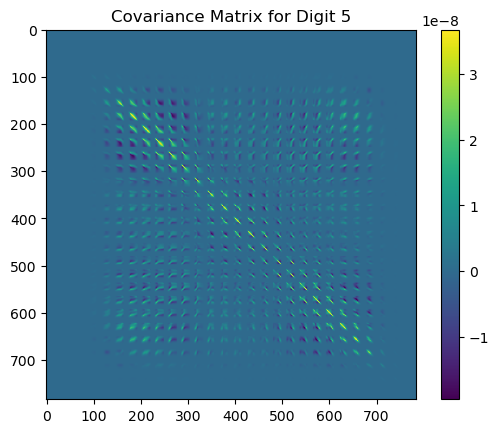

In [4]:
# Covariance matrix for digit 5
plt.imshow(cov_matrix[5], interpolation='nearest')
plt.title(f'Covariance Matrix for Digit 5')
plt.colorbar()
plt.show()

In [5]:
class GDA:
    def __init__(self):
        self.mean = []
        self.pooled_cov = None
        self.labels = None
        self.priors = []
        self.list_cov = []
    
    def fit(self, data, labels, model='lda'):
        data = data.reshape(data.shape[0], -1)
        num_examples, num_features = data.shape
        self.labels = np.unique(labels)
        self.pooled_cov = np.zeros((num_features, num_features))
        if model == 'lda':
            for label in self.labels:
                X_i = data[labels == label]
                miu_C = np.mean(X_i, axis=0)
                deviation = X_i - miu_C
                self.pooled_cov += deviation.T @ deviation
                self.mean.append(miu_C)
                self.priors.append(X_i.shape[0] / num_examples)
            self.pooled_cov += np.eye(num_features) * 1e-6
            self.pooled_cov /= num_examples
        elif model == 'qda':
            for label in self.labels:
                self.pooled_cov = np.zeros((num_features, num_features))
                X_i = data[labels == label]
                miu_C = np.mean(X_i, axis=0)
                deviation = X_i - miu_C
                self.mean.append(miu_C)
                self.priors.append(X_i.shape[0] / num_examples)
                self.pooled_cov += deviation.T @ deviation
                self.pooled_cov += np.eye(num_features) * 1e-5
                self.list_cov.append(self.pooled_cov / len(X_i))
            
    def predict(self, data, model='lda'):
        data = data.reshape(data.shape[0], -1)
        predictions = []
        if model == 'lda':
            inv_cov_means = np.stack([np.linalg.solve(self.pooled_cov, mean) for mean in self.mean])
            term1 = inv_cov_means @ data.T
            term2 = np.array([0.5 * (mean.T @ inv_cov_mean) for mean, inv_cov_mean in zip(self.mean, inv_cov_means)]).reshape(-1, 1)
            scores = term1 - term2 + np.log(self.priors).reshape(-1, 1)
        elif model == 'qda':
            scores = np.zeros((len(self.labels), data.shape[0]))
            for idx, label in enumerate(self.labels):
                mean_matrix = self.mean[idx] * np.ones((data.shape[0], 1))
                diff = data - mean_matrix
                inv_diff = np.linalg.solve(self.list_cov[idx], diff.T).T
                first_term = -0.5 * np.sum(diff * inv_diff, axis=1)
                _, logdet = np.linalg.slogdet(self.list_cov[idx])                  
                second_term = -0.5 * logdet
                third_term = np.log(self.priors[idx])
                scores[idx] = first_term + second_term + third_term 
        # Map indices to labels
        prediction_indices = np.argmax(scores, axis=0)
        predictions = np.array(self.labels)[prediction_indices]
        return predictions

In [6]:
# Model Accuracy
model = GDA()
model.fit(mnist_split_training_data, mnist_split_training_labels, 'qda')
prediction = model.predict(mnist_valid_data, 'qda')

print(f"Accuracy: {evaluate(prediction, mnist_valid_labels)}")

Accuracy: 0.9311


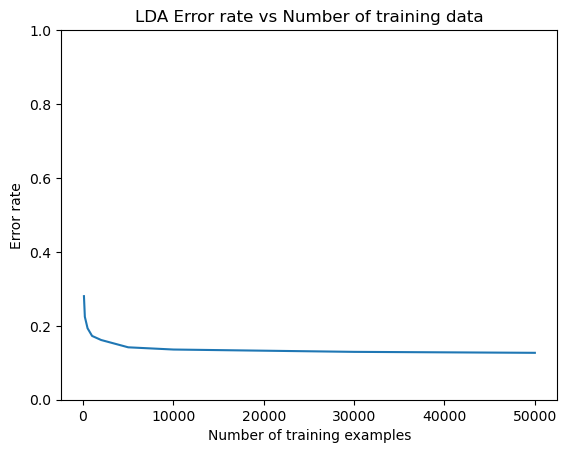

In [7]:
# Plot of LDA error rate vs number of training data
num = [100, 200, 500, 1000, 2000, 5000, 10000, 30000, 50000]
errors = []

for i in num:
    lda = GDA()
    lda.fit(mnist_split_training_data[:i], mnist_split_training_labels[:i])
    prediction = lda.predict(mnist_valid_data)
    errors.append(error_eval(prediction, mnist_valid_labels))

# Draw
plt.xlabel('Number of training examples')
plt.ylabel('Error rate')
plt.ylim(0, 1)
plt.title('LDA Error rate vs Number of training data')
plt.plot(num, errors)
plt.show()

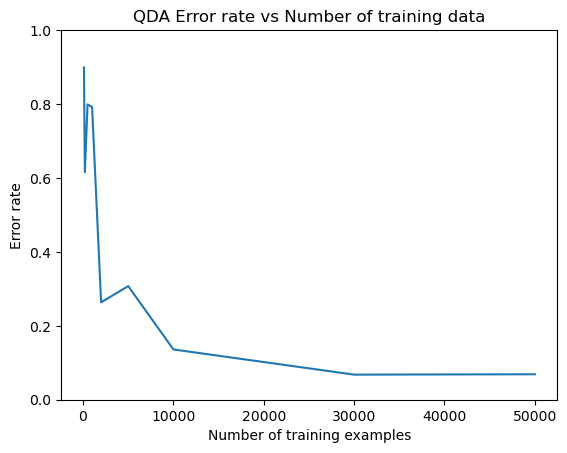

In [8]:
# Plot of QDA error rate vs number of training data
num = [100, 200, 500, 1000, 2000, 5000, 10000, 30000, 50000]
errors = []

for i in num:
    qda = GDA()
    qda.fit(mnist_split_training_data[:i], mnist_split_training_labels[:i], 'qda')
    prediction = qda.predict(mnist_valid_data, 'qda')
    errors.append(error_eval(prediction, mnist_valid_labels))

# Draw
plt.xlabel('Number of training examples')
plt.ylabel('Error rate')
plt.ylim(0, 1)
plt.title('QDA Error rate vs Number of training data')
plt.plot(num, errors)
plt.show()

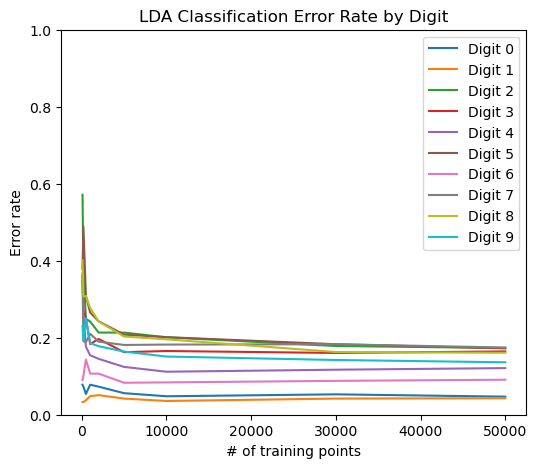

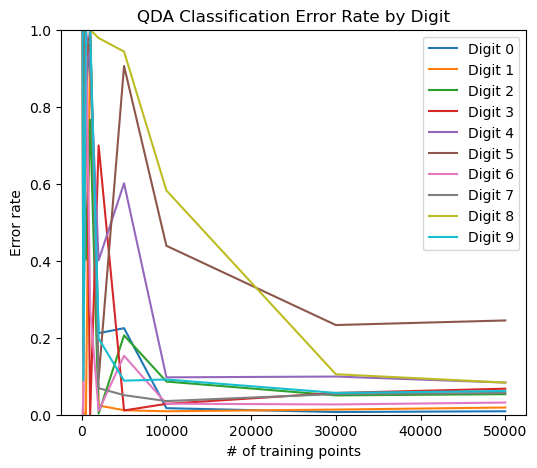

In [9]:
# Plot of validation error versus the number of training points for each digit
# Training on all, but extract specific digit of prediction to compare
num = [100, 200, 500, 1000, 2000, 5000, 10000, 30000, 50000]
digits = np.unique(mnist_training_labels)
error_rates = {digit: {'LDA': [], 'QDA': []} for digit in digits}

for digit in digits:
    idx = (mnist_valid_labels == digit)
    for i in num:
        # LDA
        lda = GDA()
        lda.fit(mnist_split_training_data[:i], mnist_split_training_labels[:i])
        prediction = lda.predict(mnist_valid_data)
        error_rates[digit]['LDA'].append(error_eval(prediction[idx], mnist_valid_labels[idx]))
        # QDA
        qda = GDA()
        qda.fit(mnist_split_training_data[:i], mnist_split_training_labels[:i], 'qda')
        prediction = qda.predict(mnist_valid_data, 'qda')
        error_rates[digit]['QDA'].append(error_eval(prediction[idx], mnist_valid_labels[idx]))


# Plot for LDA
plt.figure(figsize=(6, 5))
for digit in digits:
    plt.plot(num, error_rates[digit]['LDA'], label=f'Digit {digit}')
plt.xlabel('# of training points')
plt.ylabel('Error rate')
plt.ylim(0, 1)
plt.title('LDA Classification Error Rate by Digit')
plt.legend()
plt.show()

# Plot for QDA
plt.figure(figsize=(6, 5))
for digit in digits:
    plt.plot(num, error_rates[digit]['QDA'], label=f'Digit {digit}')
plt.xlabel('# of training points')
plt.ylabel('Error rate')
plt.ylim(0, 1)
plt.title('QDA Classification Error Rate by Digit')
plt.legend()
plt.show()

### Prediction

In [11]:
# MNIST Prediction
model = GDA()
model.fit(normalized_mnist_training_data, mnist_training_labels, 'qda')
prediction = model.predict(mnist_valid_data, 'qda')

print(f"MNIST Validation Accuracy: {evaluate(prediction, mnist_valid_labels)}")

MNIST Validation Accuracy: 0.945


In [12]:
# LDA training: 0.8783, test: 0.845
# QDA training 0.945, test: 0.923
# Remember to add 'qda', if using qda
mnist_test_pred = model.predict(mnist_test_data, 'qda')
results_to_csv(mnist_test_pred)

In [13]:
# Spam Area
spam_split_training_data, spam_split_training_labels, spam_valid_data, spam_valid_labels = train_val_split(spam_training_data, spam_training_labels, 10000)

In [14]:
# SPAM Predictioin
spam_model = GDA()
spam_model.fit(spam_training_data, spam_training_labels, 'qda')
prediction = spam_model.predict(spam_valid_data, 'qda')

print(f"Spam Validation Accuracy: {evaluate(prediction, spam_valid_labels)}")

Spam Validation Accuracy: 0.8333732917765524


In [15]:
# LDA training 0.8235, test 0.83
# QDA training 0.833, test 0.843
# Remember to add 'qda' if using qda
spam_test_pred = spam_model.predict(spam_test_data, 'qda')
results_to_csv(spam_test_pred)

### Isocontours

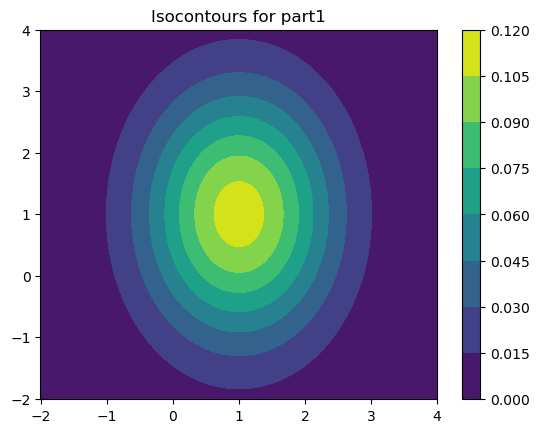

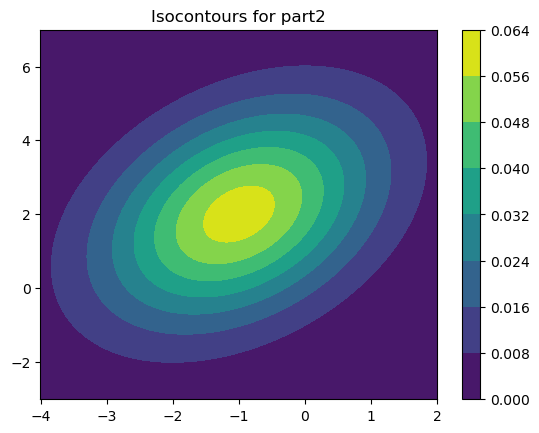

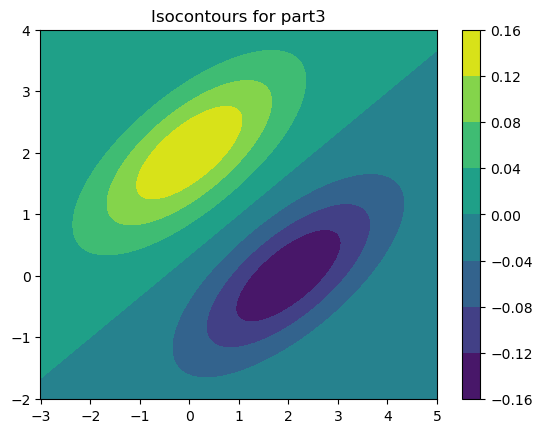

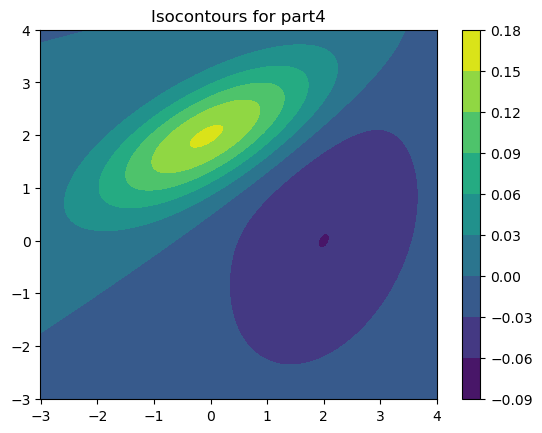

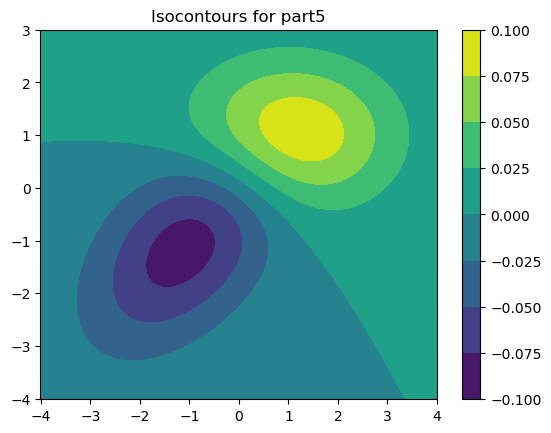

In [17]:
# Isocontours of Normal Distributions
# Helper func to get z from f(miu, sigma)
def get_multivariate_normal_distribution(miu, sigma, x, y):
    pos = np.dstack((x, y))  # Create a grid of points
    return multivariate_normal(miu, sigma).pdf(pos)

# part1
x_1, y_1 = np.mgrid[-2.01:4.01:.01, -2.01:4.01:.01]
miu_1, sigma_1 = np.array([1, 1]), np.array([[1, 0], [0, 2]])
z_1 = get_multivariate_normal_distribution(miu_1, sigma_1, x_1, y_1)
plt.contourf(x_1, y_1, z_1)
plt.colorbar()
plt.title('Isocontours for part1')
plt.show()

# part2
x_2, y_2 = np.mgrid[-4.01:2.01:.01, -3.02:7.01:.01]
miu_2, sigma_2 = np.array([-1, 2]), np.array([[2, 1], [1, 4]])
z_2 = get_multivariate_normal_distribution(miu_2, sigma_2, x_2, y_2)
plt.contourf(x_2, y_2, z_2)
plt.colorbar()
plt.title('Isocontours for part2')
plt.show()

# part3
x_3, y_3 = np.mgrid[-3.01:5.01:.01, -2.01:4.01:.01]
miu_3_1, sigma_3, miu_3_2 = np.array([0, 2]), np.array([[2, 1], [1, 1]]), np.array([2, 0])
z_3_1 = get_multivariate_normal_distribution(miu_3_1, sigma_3, x_3, y_3)
z_3_2 = get_multivariate_normal_distribution(miu_3_2, sigma_3, x_3, y_3)
plt.contourf(x_3, y_3, z_3_1 - z_3_2)
plt.colorbar()
plt.title('Isocontours for part3')
plt.show()

# part4
x_4, y_4 = np.mgrid[-3.01:4.01:.01, -3.01:4.01:.01]
miu_4_1, sigma_4_1 = np.array([0, 2]), np.array([[2, 1], [1, 1]])
miu_4_2, sigma_4_2 = np.array([2, 0]), np.array([[2, 1], [1, 4]])
z_4_1 = get_multivariate_normal_distribution(miu_4_1, sigma_4_1, x_4, y_4)
z_4_2 = get_multivariate_normal_distribution(miu_4_2, sigma_4_2, x_4, y_4)
plt.contourf(x_4, y_4, z_4_1 - z_4_2)
plt.colorbar()
plt.title('Isocontours for part4')
plt.show()

# part5
x_5, y_5 = np.mgrid[-4.01:4.01:.01, -4.01:3.01:.01]
miu_5_1, sigma_5_1 = np.array([1, 1]), np.array([[2, 0], [0, 1]])
miu_5_2, sigma_5_2 = np.array([-1, -1]), np.array([[2, 1], [1, 2]])
z_5_1 = get_multivariate_normal_distribution(miu_5_1, sigma_5_1, x_5, y_5)
z_5_2 = get_multivariate_normal_distribution(miu_5_2, sigma_5_2, x_5, y_5)
plt.contourf(x_5, y_5, z_5_1 - z_5_2)
plt.colorbar()
plt.title('Isocontours for part5')
plt.show()

Sample_mean = [2.68846045 5.3888394 ]
Covariance Matrix: [[7.42292904 3.00253936]
 [3.00253936 4.78474509]]
Eigenvalues: [9.38335628 2.82431785], 
Eigenvectors: [[ 0.83732346 -0.54670781]
 [ 0.54670781  0.83732346]]


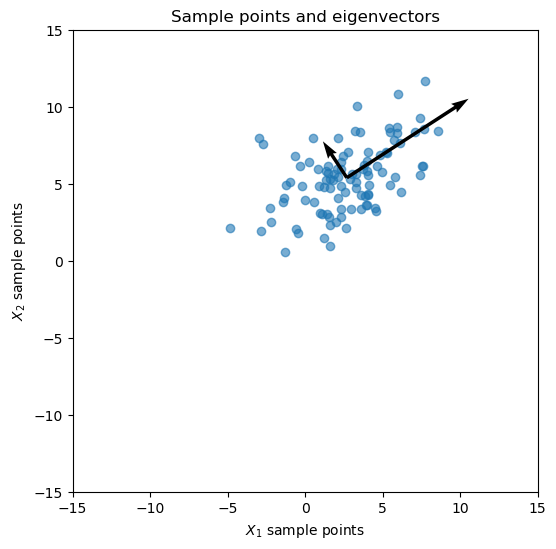

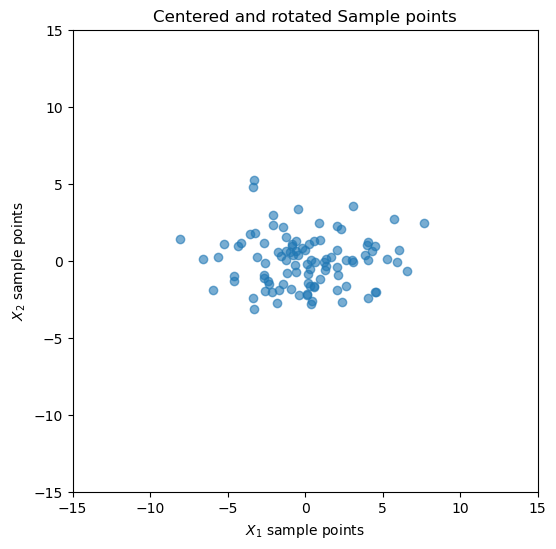

In [19]:
# Q7
np.random.seed(42)
X_1 = np.random.normal(3, np.sqrt(9), 100)
X_2 = 0.5 * X_1 + np.random.normal(4, np.sqrt(4), 100)
sample_points = np.column_stack((X_1, X_2))

# Part1
sample_mean = np.mean(sample_points, axis=0)
print(f"Sample_mean = {sample_mean}")

# Part2
cov_matrix = np.cov(sample_points, rowvar=False)
print(f"Covariance Matrix: {cov_matrix}")

# Part3
eigenvalues, eigenvectors = np.linalg.eig(cov_matrix)
print(f"Eigenvalues: {eigenvalues}, \nEigenvectors: {eigenvectors}")

# Part 4
plt.figure(figsize=(6, 6))
plt.scatter(X_1, X_2, alpha=0.6)
plt.title('Sample points and eigenvectors')
plt.xlabel('$X_1$ sample points')
plt.ylabel('$X_2$ sample points')
plt.axis([-15, 15, -15, 15])
# Covariance Eigenvectors
pos_x, pos_y = [sample_mean[0], sample_mean[0]], [sample_mean[1], sample_mean[1]]
dir_x = [eigenvalues[0] * eigenvectors[0][0], eigenvalues[1] * eigenvectors[0][1]]
dir_y = [eigenvalues[0] * eigenvectors[1][0], eigenvalues[1] * eigenvectors[1][1]]
plt.quiver(pos_x, pos_y, dir_x, dir_y, angles='xy', scale_units='xy', scale=1) # ([X, Y], U, V)
plt.show()

# Part5
rotated_centered_points = (eigenvectors.T @ (sample_points - sample_mean).T).T
plt.figure(figsize=(6, 6))
plt.scatter(rotated_centered_points[:, 0], rotated_centered_points[:, 1], alpha=0.6)
plt.title('Centered and rotated Sample points')
plt.xlabel('$X_1$ sample points')
plt.ylabel('$X_2$ sample points')
plt.axis([-15, 15, -15, 15])
plt.show()